<a href="https://colab.research.google.com/github/sayan0506/HardHead-Detection-for-Safety-Surveilance-using-YoloV3/blob/main/Personal_Safety_Equipment_Detection_System_using_YoloV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implement YoloV3 based Safety Equipment Detection using Tensorflow**

• **Task: Build A Personal Safety Equipment Detection System**

In this noteboook we will try to build a Helmet Detection system from real time images in contruction sites as a personal safety system. The system should detect either head or helmet independently from the images. YoloV3(You Only Look Once Version 3) is an efficient model which has darknet as it's backbone, will be used here to efficiently and fast detect and process the images/video-frame in real time scenarios.

## **Install Dependencies**

In [ ]:
# install tensorflow gpu
!pip install tensorflow-gpu==2.4.2

# install opencv = 4.1.1.26
!pip install opencv-python==4.1.1.26

# install lxml(helps to parse xml annotations)
!pip install lxml

# install tqdm(it helps to visualize the progress bar while iterating a loop)
# it adds a smart progress meter in loop execution
!pip install tqdm

## **Import Dependencies**

In [22]:
import zipfile
import os
import random
import numpy as np
from absl import logging

import tensorflow as tf

import time
#hashlib helps to encypt the data so that data does not get changes while parsing
import hashlib

import lxml.etree # to process xml tree structure in Pascal Voc annot files
import tqdm

## **Mount Drive**

Drive mail_id: hazrasayan2020@gmail.com

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## **Environment Setup**

**Improve Reproducibility**

In [3]:
# improve reproducibility and make it more deterministic
os.environ['TF_CUDNN_DETEREMINISTIC'] = '1'
random.seed(hash('setting random seeds') % 2**32 -1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash('by removing stochasticity')% 2**32 -1)

**GPU Utilization**

In [4]:
# system setup 
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1999536518186882625, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14509932544
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12908933574867067331
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [8]:
# checking GPU utilization
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
  raise SystemError('GPU device not found!')

print(f'Found GPU at {device}')

Found GPU at /device:GPU:0


## **Dataset Load**

Load the HardHat Dataset zip from drive folder

zip_path : "/content/drive/MyDrive/HardHead Dataset/HardHat_Dataset.zip"

**Define unzipping function**

In [11]:
def unzipping(src, dst):
  if not os.path.isdir(dst):
    os.mkdir(dst) # unzip path

  # unzipping to dst
  with zipfile.ZipFile(src, 'r') as zip_ref:
    zip_ref.extractall(dst)

unzip the dataset zip file

In [36]:
zip_path = '/content/drive/MyDrive/HardHead Dataset/HardHat_Dataset.zip'
dataset_path = 'Hardhat_dataset'

# unzip
unzipping(zip_path, dataset_path)

## **Data Preperation**

Define class dictionary

In [13]:
classifiers = ['helmet', 'head']

id_list = [i for i in range(len(classifiers))]

class_dict = dict(zip(classifiers, id_list))

print(f'Class dictionary for hardhead dataset {class_dict}')


Class dictionary for hardhead dataset {'helmet': 0, 'head': 1}


**Write classes.names text file to store the class list**

In [38]:
labels_str = '\n'.join(sorted(class_dict.keys()))
drive_path = '/content/drive/MyDrive/HardHead Dataset/' 

# class file path(.names is a text file to store the object labels)
class_path = '/content/drive/MyDrive/HardHead Dataset/hardhat_classes.names'

with open(class_path, 'w') as f:
 f.write(labels_str)

**Write image_names.txt file to store the image names present in the dataset**

In [39]:
img_list = os.listdir(os.path.join(unzip_path, 'images'))
annot_list = os.listdir(os.path.join(unzip_path, 'annotations'))

# verify lenght with annotation lenghts
assert len(img_list) == len(annot_list)
print(f'Total image samples in the dataset {len(img_list)}')

img_file_path = os.path.join(drive_path, 'hardhat_image_names.txt')
img_id_list = [id for id,_ in enumerate(img_list)]
img_names = [img.split('.')[0] for img in img_list]
print(f'Sample image  name: {img_names[0]}')

img_dict = dict(zip(img_names, img_id_list))

imgs_str = '\n'.join(sorted(img_dict.keys()))

# image names file path
with open(img_file_path, 'w') as f:
 f.write(imgs_str)

Total image samples in the dataset 4750
Sample image  name: hard_hat_workers1858


#### **Prepare TfRecords**

**Function to build the tf-records from annotaion files and images**

In [20]:
def build_example(data_dir, annotation, class_map):
    img_path = os.path.join(
        data_dir, 'images', annotation['filename'])
    img_raw = open(img_path, 'rb').read()
    # encrypt images
    key = hashlib.sha256(img_raw).hexdigest()

    width = int(annotation['size']['width'])
    height = int(annotation['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    views = []
    difficult_obj = []
    if 'object' in annotation:
        for obj in annotation['object']:
            difficult = bool(int(obj['difficult']))
            difficult_obj.append(int(difficult))

            xmin.append(float(obj['bndbox']['xmin']) / width)
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width)
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(class_map[obj['name']])
            truncated.append(int(obj['truncated']))
            views.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[
            annotation['filename'].encode('utf8')])),
        'image/key/sha256': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=['jpeg'.encode('utf8')])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'image/object/difficult': tf.train.Feature(int64_list=tf.train.Int64List(value=difficult_obj)),
        'image/object/truncated': tf.train.Feature(int64_list=tf.train.Int64List(value=truncated)),
        'image/object/view': tf.train.Feature(bytes_list=tf.train.BytesList(value=views)),
    }))
    return example


**Define function to parse xml annotations**

In [21]:
def parse_xml(xml):
    if not len(xml):
        return {xml.tag: xml.text}
    result = {}
    for child in xml:
        child_result = parse_xml(child)
        if child.tag != 'object':
            result[child.tag] = child_result[child.tag]
        else:
            if child.tag not in result:
                result[child.tag] = []
            result[child.tag].append(child_result[child.tag])
    return {xml.tag: result}

**Class map**

In [25]:
class_map = {name: idx for idx, name in enumerate(
    open(class_path).read().splitlines())}
print(f'Class mapping loaded: {class_map}')

Class mapping loaded: {'head': 0, 'helmet': 1}


**Fetch image list**

In [46]:
image_list = open(img_file_path).read().splitlines()
print("Image list loaded: ", len(image_list))

Image list loaded:  4750


**Create Tfrecords**

In [59]:
# define tfrecords metadata
train_record = os.path.join(drive_path, 'hardhat_train.tfrecord')

# writer object
writer = tf.io.TFRecordWriter(train_record)

for name in tqdm.tqdm(image_list[:3]):
  annotation_xml = os.path.join(dataset_path, 'annotations', name + '.xml')
  # read annotation files
  annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
  # parse the annotation xml
  annotation = parse_xml(annotation_xml)['annotation']
  # build tfrecords
  tf_example = build_example(dataset_path, annotation, class_map)
  writer.write(tf_example.SerializeToString())

writer.close()
print('\nTfrecord conversion is Done!')

100%|██████████| 3/3 [00:00<00:00, 316.68it/s]


Tfrecord conversion is Done!


In [68]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md#conversion-script-outline-conversion-script-outline
# Commented out fields are not required in our project
IMAGE_FEATURE_MAP = {
    # 'image/width': tf.io.FixedLenFeature([], tf.int64),
    # 'image/height': tf.io.FixedLenFeature([], tf.int64),
    # 'image/filename': tf.io.FixedLenFeature([], tf.string),
    # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
    # 'image/key/sha256': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    # 'image/format': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
    'image/object/class/text': tf.io.VarLenFeature(tf.string),
    # 'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    # 'image/object/difficult': tf.io.VarLenFeature(tf.int64),
    # 'image/object/truncated': tf.io.VarLenFeature(tf.int64),
    # 'image/object/view': tf.io.VarLenFeature(tf.string),
}

In [73]:
def parse_tfrecord(tfrecord, class_table, size):
    x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
    x_train = tf.image.decode_jpeg(x['image/encoded'], channels=3)
    x_train = tf.image.resize(x_train, (size, size))

    class_text = tf.sparse.to_dense(
        x['image/object/class/text'], default_value='')
    labels = tf.cast(class_table.lookup(class_text), tf.float32)
    y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
                        tf.sparse.to_dense(x['image/object/bbox/ymin']),
                        tf.sparse.to_dense(x['image/object/bbox/xmax']),
                        tf.sparse.to_dense(x['image/object/bbox/ymax']),
                        labels], axis=1)

    paddings = [[0, 20 - tf.shape(y_train)[0]], [0, 0]]
    y_train = tf.pad(y_train, paddings)

    return x_train, y_train

In [74]:
def load_tfrecord_dataset(file_pattern, class_file, size = 416):
  # line number
  LINE_NUMBER = tf.lookup.TextFileIndex.LINE_NUMBER
  class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(
      class_file, tf.string, 0, tf.int64, LINE_NUMBER, delimiter = "\n"), -1)
  
  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x: parse_tfrecord(x, class_table, size))

**Visualize TfRecord**

In [75]:
class_names = [c.strip for c in open(class_path).readlines()]
class_names

[<function str.strip>, <function str.strip>]

In [76]:
dataset = load_tfrecord_dataset('/content/drive/MyDrive/HardHead Dataset/hardhat_train.tfrecord', class_path, 416)

In [80]:
import cv2

In [84]:
def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

In [89]:
dataset = dataset.shuffle(512)

for image, labels in dataset.take(1):
    boxes = []
    scores = []
    classes = []
    for x1, y1, x2, y2, label in labels:
        if x1 == 0 and x2 == 0:
            continue

        boxes.append((x1, y1, x2, y2))
        scores.append(1)
        classes.append(label)
    nums = [len(boxes)]
    boxes = [boxes]
    scores = [scores]
    classes = [classes]
    print(classes)
    logging.info('labels:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                            np.array(scores[0][i]),
                                            np.array(boxes[0][i])))

    img = cv2.cvtColor(image.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    cv2.imwrite('new.jpg', img)
    #logging.info('output saved to: {}'.format(FLAGS.output))


[[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>]]


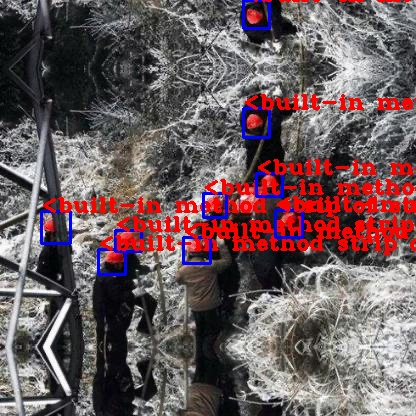

In [90]:
from IPython.display import Image

Image(filename = '/content/new.jpg')